# Non-Transformed Temporal Similarity Search For Technical Analysis

##### Note: This example requires a KDB.AI endpoint and API key. Sign up for a free [KDB.AI account](https://kdb.ai/get-started).

This notebook demonstrates how to use KDB.AI's Non-Transformed Temporal Similarity Search (TSS) for pattern matching and technical analysis in synthetic market data. We'll generate synthetic time series data, insert it into a KDB.AI table, and then perform similarity searches to identify specific patterns.

Agenda:

1. Dependencies, Imports & Setup
2. Define KDB.AI Session
3. Load Synthetic Market Time Series Data
4. Create KDB.AI Schema & Table
5. Pattern Matching and Visualization

### 1. Dependencies, Imports & Setup

In order to successfully run this sample, note the following steps depending on where you are running this notebook:

-***Run Locally / Private Environment:*** The [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` will guide you on prerequisites and how to run this with Jupyter.


-***Colab / Hosted Environment:*** Open this notebook in Colab and run through the cells.

In [1]:
!pip install kdbai_client
!pip install yfinance==0.2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kdbai_client as kdbai
import time
import os
from getpass import getpass
import yfinance as yf
import pandas as pd

## 2. Load Synthetic Market Time Series Data
Let's generate 10 million data points for a hypothetical stock using a random walk. We wil have the following data:

- timestamp: The timestamp for the data
- close: The price of the stock being traded at a certain timestamp

To make the data easier to work with, we will normalize it before inserting into our table.

In [3]:
# Download AAPL data for the last year
aapl_data = yf.download("AAPL", period="1y")

# Reset index to make 'Date' a column
aapl_data = aapl_data.reset_index()

# Rename 'Date' to 'timestamp' and 'Close' to 'close'
aapl_data = aapl_data.rename(columns={"Date": "timestamp", "Close": "close"})

# Select only 'timestamp' and 'close' columns
aapl_data = aapl_data[["timestamp", "close"]]
# Assign downloaded data to synthetic_data
synthetic_data = aapl_data

<ipython-input-3-cdbb475b43dd>:17: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_series = pd.date_range(start=start_time, periods=n_points, freq='S')


In [ ]:
[synthetic_data]

[                  timestamp     close
 0       2024-01-01 09:30:00  0.473890
 1       2024-01-01 09:30:01  0.474245
 2       2024-01-01 09:30:02  0.473890
 3       2024-01-01 09:30:03  0.473535
 4       2024-01-01 09:30:04  0.473179
 ...                     ...       ...
 9999995 2024-04-26 03:16:35  0.784014
 9999996 2024-04-26 03:16:36  0.784369
 9999997 2024-04-26 03:16:37  0.784014
 9999998 2024-04-26 03:16:38  0.784369
 9999999 2024-04-26 03:16:39  0.784014
 
 [10000000 rows x 2 columns]]

Now we can plot the data, to get some idea of how it looks.

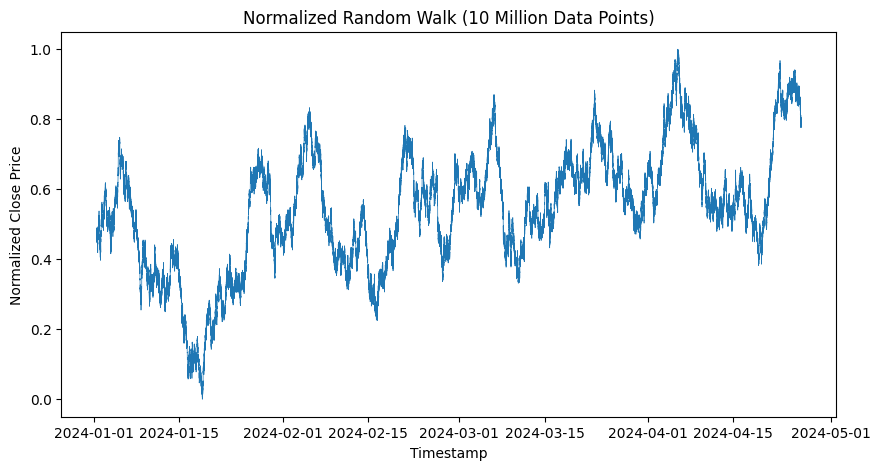

In [4]:
# Step 2: Plot the normalized random walk data
plt.figure(figsize=(10, 5))
plt.plot(synthetic_data['timestamp'], synthetic_data['close'], linewidth=0.5)
plt.title('Normalized Random Walk (10 Million Data Points)')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Close Price')
plt.show()

## 3. Define KDB.AI Session
KDB.AI comes in two offerings:

KDB.AI Cloud - For experimenting with smaller generative AI projects with a vector database in our cloud.
KDB.AI Server - For evaluating large scale generative AI applications on-premises or on your own cloud provider.
Depending on which you use there will be different setup steps and connection details required.

In this notebook, we will be using KDB.AI Cloud.
To use KDB.AI Cloud, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free here.

You can connect to a KDB.AI Cloud session using kdbai.Session and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables KDBAI_ENDPOINTS and KDBAI_API_KEY exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect. If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

In [6]:
# Set up KDB.AI endpoint and API key
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else "https://cloud.kdb.ai/instance/d9yetr3pdr"
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

KDB.AI endpoint: https://cloud.kdb.ai/instance/d9yetr3pdr
KDB.AI API key: ··········


In [7]:
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### 3. Create KDB.AI Schema & Table

In [8]:
# get the database connection. Default database name is 'default'
database = session.database('default')

# First ensure the table does not already exist
try:
    database.table("synthetic_data").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [9]:
# Set up the schema and indexes for KDB.AI table, specifying embeddings column with 384 dimensions, Euclidean Distance, and flat index
schema = [
    {"name": "timestamp", "type": "datetime64[ns]"},
    {"name": "close", "type": "float64"}
]

In [10]:
# get the database connection. Default database name is 'default'
database = session.database('default')

# First ensure the table does not already exist
try:
    database.table("synthetic_data").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

# Create the table
table = database.create_table("synthetic_data", schema)

In [11]:
synthetic_data

,timestamp,close
0,2024-01-01 09:30:00,0.473890
1,2024-01-01 09:30:01,0.474245
2,2024-01-01 09:30:02,0.473890
3,2024-01-01 09:30:03,0.473535
4,2024-01-01 09:30:04,0.473179
...,...,...
9999995,2024-04-26 03:16:35,0.784014
9999996,2024-04-26 03:16:36,0.784369
9999997,2024-04-26 03:16:37,0.784014
9999998,2024-04-26 03:16:38,0.784369


In [12]:
# Insert data into the table in batches
for i in range(0, len(synthetic_data), 600000):
    table.insert(synthetic_data.iloc[i:i+600000])

In [13]:
# Verify data insertion
print(table.query())

                  timestamp     close
0       2024-01-01 09:30:00  0.473890
1       2024-01-01 09:30:01  0.474245
2       2024-01-01 09:30:02  0.473890
3       2024-01-01 09:30:03  0.473535
4       2024-01-01 09:30:04  0.473179
...                     ...       ...
9999995 2024-04-26 03:16:35  0.784014
9999996 2024-04-26 03:16:36  0.784369
9999997 2024-04-26 03:16:37  0.784014
9999998 2024-04-26 03:16:38  0.784369
9999999 2024-04-26 03:16:39  0.784014

[10000000 rows x 2 columns]


### 4. Pattern Matching and Visualization

Now we will perform pattern matching using the predefined stock price patterns ('uptrend', 'downtrend', 'double bottom', 'cup and handle', 'head and shoulders'). Here's what we do:

1. **Pattern Normalization**: Each pattern is normalized to a range between 0 and 1. This standardization is crucial for accurate comparison across different scales in the synthetic stock data.

2. **Similarity Search**: We conduct a similarity search for each normalized pattern against the synthetic market time series data stored in KDB.AI. This process involves querying the most similar sequence within the database that matches our synthetic patterns.

3. **Visualization**: For each pattern, we visualize both the normalized synthetic pattern and the most similar pattern found in the synthetic data. This visual representation helps in understanding how well our similarity search is performing.

4. **Result Analysis**: The results from the similarity search are printed, including the most similar timestamp and pattern in the synthetic data. We also attempt to match these results back to the original synthetic data to validate and inspect the similarity.

We can use this strategy to utilize synthetic price movements to find interesting price movements in real data.



Most Similar Synthetic Pattern (at 2024-01-02 03:16:06):
nnDist                  3.807829
nnIdx                      63966
timestamp    2024-01-02 03:16:06
close                   0.472469
Name: 0, dtype: object
[0.4724689165186501, 0.47211367673179394, 0.47175843694493785, 0.4714031971580817, 0.47175843694493785, 0.4714031971580817, 0.47175843694493785, 0.47211367673179394, 0.47175843694493785, 0.4714031971580817, 0.47104795737122557, 0.4714031971580817, 0.47104795737122557, 0.4714031971580817, 0.47104795737122557, 0.4714031971580817, 0.47104795737122557, 0.4714031971580817, 0.47175843694493785, 0.47211367673179394, 0.47175843694493785, 0.47211367673179394, 0.4724689165186501, 0.4728241563055062, 0.4724689165186501, 0.4728241563055062, 0.47317939609236237, 0.4728241563055062, 0.47317939609236237, 0.4728241563055062, 0.4724689165186501, 0.47211367673179394, 0.47175843694493785, 0.47211367673179394, 0.47175843694493785, 0.47211367673179394, 0.47175843694493785, 0.47211367673179394, 0.4

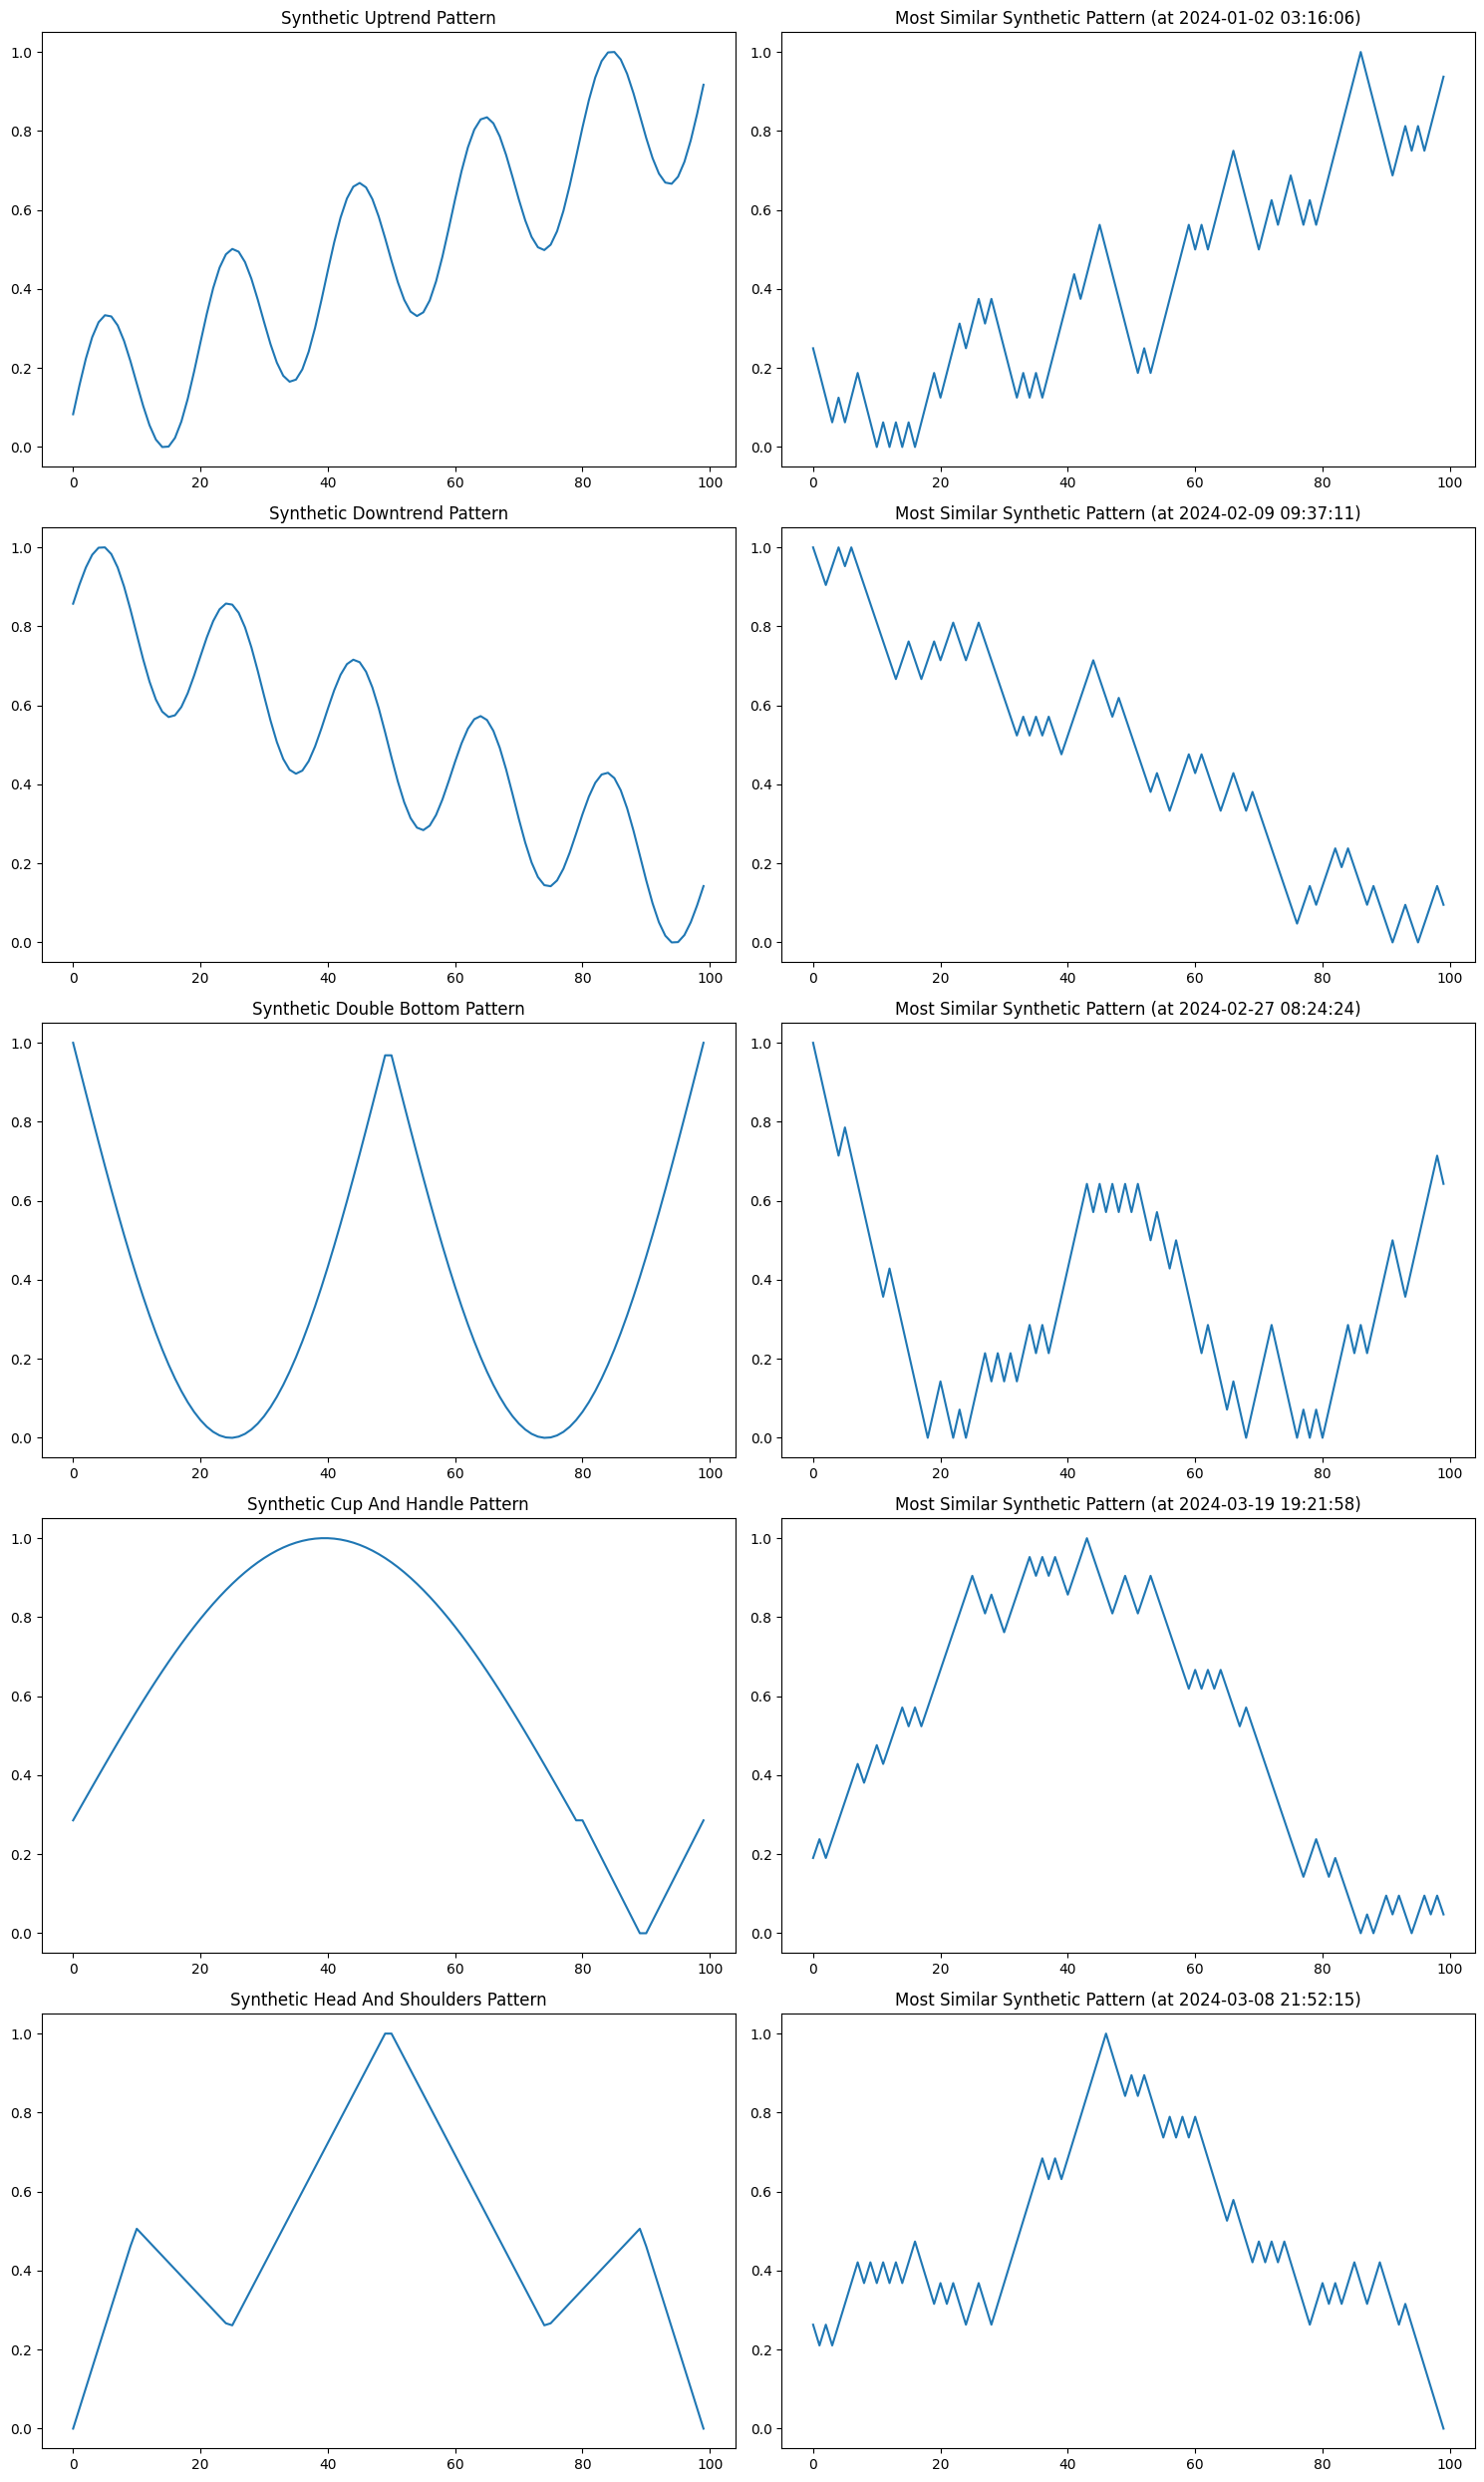

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def create_pattern(pattern_type, length=100):
    if pattern_type == 'head_and_shoulders':
        # Define the x positions of the key points
        points_x = np.array([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]) * length
        points_y = np.array([0.8, 1, 0.9, 1.2, 0.9, 1, 0.8])

        # Generate the full x array
        full_x = np.linspace(0, length, length)

        # Interpolate to get the full y values
        full_y = np.interp(full_x, points_x, points_y)

        return full_y

    elif pattern_type == 'cup_and_handle':
        # Cup
        x_cup = np.linspace(0, np.pi, int(0.8 * length))
        cup = np.sin(x_cup) * 0.5 + 0.5

        # Handle
        x_handle = np.linspace(0, 1, int(0.2 * length))
        handle = np.linspace(cup[-1], cup[-1] - 0.2, int(0.1 * length))
        handle = np.concatenate([handle, np.linspace(handle[-1], handle[0], int(0.1 * length))])

        return np.concatenate([cup, handle])

    if pattern_type == 'uptrend':
        x = np.linspace(0, 1, length)
        return 0.8 * x + 0.2 * np.sin(10 * np.pi * x) + 0.5

    elif pattern_type == 'downtrend':
        x = np.linspace(0, 1, length)
        return -0.8 * x + 0.2 * np.sin(10 * np.pi * x) + 1

    elif pattern_type == 'double_bottom':
        x = np.linspace(0, 1, length)
        return 0.5 - 0.3 * np.abs(np.sin(2 * np.pi * x)) + 0.2

    else:
        raise ValueError("Invalid pattern type")


# Define the patterns to search for
patterns = {
    'uptrend': create_pattern('uptrend'),
    'downtrend': create_pattern('downtrend'),
    'double_bottom': create_pattern('double_bottom'),
    'cup_and_handle': create_pattern('cup_and_handle'),
    'head_and_shoulders': create_pattern('head_and_shoulders'),
}

# Perform similarity search for each pattern and plot results
fig, axs = plt.subplots(len(patterns), 2, figsize=(15, 5*len(patterns)))

for i, (pattern_name, pattern_data) in enumerate(patterns.items()):
    # Normalize the pattern data
    pattern_data = (pattern_data - np.min(pattern_data)) / (np.max(pattern_data) - np.min(pattern_data))

    # Search for similar vectors in synthetic data
    nn_result = table.search(vectors={'close': [pattern_data.tolist()]}, n=1, type="tss")[0]

    # Plot synthetic pattern
    axs[i, 0].plot(pattern_data)
    axs[i, 0].set_title(f'Synthetic {pattern_name.replace("_", " ").title()} Pattern')

    # Plot most similar synthetic pattern
    similar_pattern = nn_result.iloc[0]
    print(f"\nMost Similar Synthetic Pattern (at {similar_pattern['timestamp']}):")
    print(similar_pattern)

    # Try to find the matching pattern in the original synthetic data
    matching_index = synthetic_data[synthetic_data['timestamp'] == similar_pattern['timestamp']].index

    if not matching_index.empty:
        start_index = matching_index[0]
        end_index = start_index + 100

        if end_index > len(synthetic_data):
            end_index = len(synthetic_data)

        matching_data = synthetic_data.iloc[start_index:end_index]
        close_values_vector = matching_data['close'].tolist()

        print(close_values_vector)

        print("\nMatching data from original synthetic data:")
        print(matching_data)

        if not matching_data.empty:
            synthetic_pattern = matching_data['close'].values  # Ensure this is a NumPy array

            if len(synthetic_pattern) > 0:
                synthetic_pattern = (synthetic_pattern - np.min(synthetic_pattern)) / (np.max(synthetic_pattern) - np.min(synthetic_pattern))
                axs[i, 1].plot(synthetic_pattern)
                axs[i, 1].set_title(f'Most Similar Synthetic Pattern (at {similar_pattern["timestamp"]})')
            else:
                print("Error: Empty synthetic pattern")
        else:
            print("Error: No matching data found")
    else:
        print("No matching timestamp found.")

plt.tight_layout()
plt.show()